In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nickanhel","key":"14007279cf1094729cf457f7d64bc424"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mczielinski/bitcoin-historical-data
!unzip -q bitcoin-historical-data.zip -d /content/data
!ls /content/data

Dataset URL: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data
License(s): CC-BY-SA-4.0
btcusd_1-min_data.csv


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv("/content/data/btcusd_1-min_data.csv")

df.sort_values("Timestamp", inplace=True)
df.reset_index(drop=True, inplace=True)

df.head(10)

,Timestamp,Open,High,Low,Close,Volume,datetime
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00+00:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00+00:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00+00:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00+00:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00+00:00
5,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:06:00+00:00
6,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:07:00+00:00
7,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:08:00+00:00
8,1.325413e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:09:00+00:00
9,1.325413e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:10:00+00:00


In [ ]:
df = df[["Timestamp", "Close"]]

# Add noise
noise = np.random.normal(0, 10, size=len(df))
df["Noisy"] = df["Close"] + noise

# Add skips
mask = np.random.rand(len(df)) < 0.3
df["Masked"] = df["Noisy"]
df.loc[mask, "Masked"] = np.nan

# Add linear interpolation
df["Interpolated"] = df["Masked"].interpolate(method="linear")

df.head(10)

,Timestamp,Close,Noisy,Masked,Interpolated
0,1.325412e+09,4.58,-0.206065,-0.206065,-0.206065
1,1.325412e+09,4.58,-16.028644,-16.028644,-16.028644
2,1.325412e+09,4.58,8.295214,NaN,-2.188488
3,1.325412e+09,4.58,11.651668,11.651668,11.651668
4,1.325412e+09,4.58,6.148158,6.148158,6.148158
5,1.325412e+09,4.58,10.835499,10.835499,10.835499
6,1.325412e+09,4.58,3.419828,NaN,0.533437
7,1.325412e+09,4.58,3.998988,NaN,-9.768624
8,1.325413e+09,4.58,-20.070686,-20.070686,-20.070686
9,1.325413e+09,4.58,29.391186,NaN,-11.745131


In [ ]:
scaler = MinMaxScaler()
data_noisy = scaler.fit_transform(df[["Noisy"]])

In [ ]:
def create_sequences(data, window_size=10):
    x, y = [], []

    for i in range(len(data) - window_size):
        x.append(data[i:i + window_size])
        y.append(data[i + window_size])

    return np.array(x), np.array(y)


window_size = 20
x, y = create_sequences(data_noisy, window_size)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [ ]:
model = Sequential()
model.add(LSTM(32, activation="tanh", return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(16, activation="tanh"))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,505 (29.32 KB)

 Trainable params: 7,505 (29.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.3,
    callbacks=[early_stop],
)

Epoch 1/10
30384/30384 ━━━━━━━━━━━━━━━━━━━━ 243s 8ms/step - loss: 1.0557e-07 - mae: 2.3675e-04 - val_loss: 1.5073e-04 - val_mae: 0.0067
Epoch 2/10
30384/30384 ━━━━━━━━━━━━━━━━━━━━ 280s 9ms/step - loss: 5.1050e-08 - mae: 1.6837e-04 - val_loss: 1.2085e-04 - val_mae: 0.0064
Epoch 3/10
30384/30384 ━━━━━━━━━━━━━━━━━━━━ 284s 9ms/step - loss: 4.0899e-08 - mae: 1.5093e-04 - val_loss: 1.0236e-04 - val_mae: 0.0058
Epoch 4/10
30384/30384 ━━━━━━━━━━━━━━━━━━━━ 288s 8ms/step - loss: 3.5395e-08 - mae: 1.4132e-04 - val_loss: 7.0649e-05 - val_mae: 0.0046
Epoch 5/10
30384/30384 ━━━━━━━━━━━━━━━━━━━━ 298s 9ms/step - loss: 3.2008e-08 - mae: 1.3477e-04 - val_loss: 6.5754e-05 - val_mae: 0.0045
Epoch 6/10
30384/30384 ━━━━━━━━━━━━━━━━━━━━ 322s 9ms/step - loss: 3.0602e-08 - mae: 1.3201e-04 - val_loss: 5.8373e-05 - val_mae: 0.0043
Epoch 7/10
30384/30384 ━━━━━━━━━━━━━━━━━━━━ 287s 8ms/step - loss: 2.9732e-08 - mae: 1.2984e-04 - val_loss: 4.2167e-05 - val_mae: 0.0035
Epoch 8/10
30384/30384 ━━━━━━━━━━━━━━━━━━━━ 287s

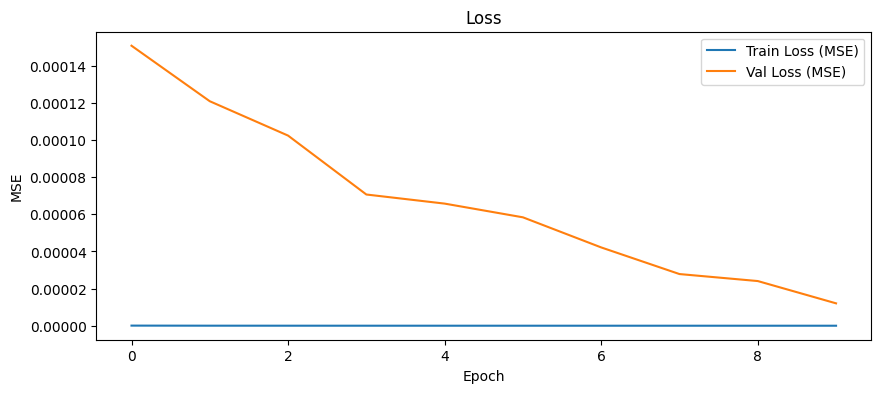

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Val Loss (MSE)")

plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")

plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(x_test)

y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(
    "Metrics",
    f"MSE: {mse:.5f}",
    f"MAE: {mae:.5f}",
    f"R²: {r2:.4f}",
    sep="\n",
)

43405/43405 ━━━━━━━━━━━━━━━━━━━━ 101s 2ms/step
Metrics
MSE: 15755867.88868
MAE: 1853.58458
R²: 0.9763


In [ ]:
start_idx = len(df) - len(y_test) - window_size
interpolated_values = df['Interpolated'].iloc[start_idx + window_size : start_idx + window_size + len(y_test)].values

results = pd.DataFrame({
    "True": y_test.flatten(),
    "Predicted": y_pred.flatten(),
    "Interpolated": interpolated_values,
})

results.head(10)

,True,Predicted,Interpolated
0,22047.548784,22034.634766,22032.630465
1,21970.664836,22051.855469,21992.612183
2,22015.708026,22027.085938,21987.976961
3,22005.925183,22029.767578,21981.431400
4,21984.319874,22029.126953,21974.885839
5,21998.556936,22018.787109,22000.410538
6,21995.600158,22018.722656,21994.618518
7,21999.273876,22018.386719,21988.826498
8,21977.940475,22020.013672,21994.592702
9,21993.254591,22011.449219,22000.358907


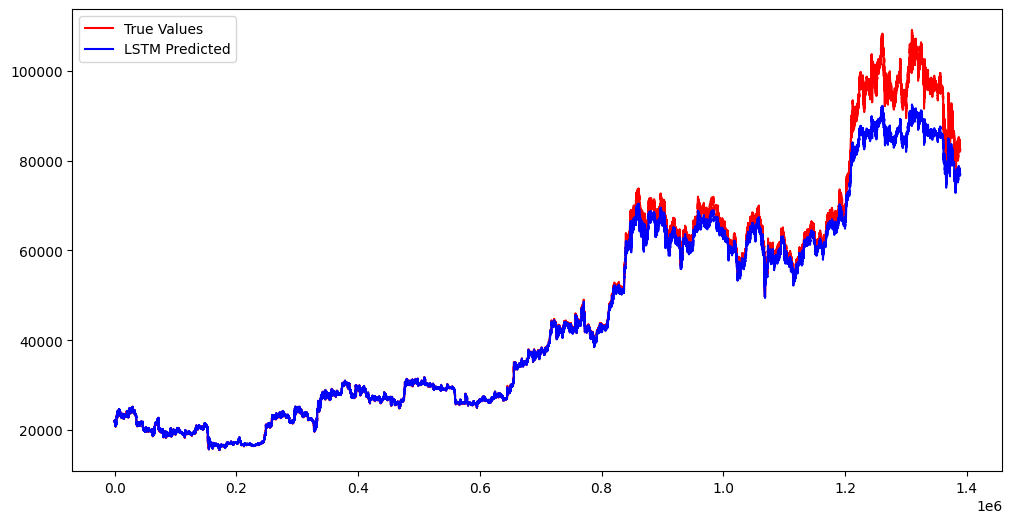

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(results["True"], label="True Values", c="red")
plt.plot(results["Predicted"], label="LSTM Predicted", c="blue")

plt.legend()
plt.show()

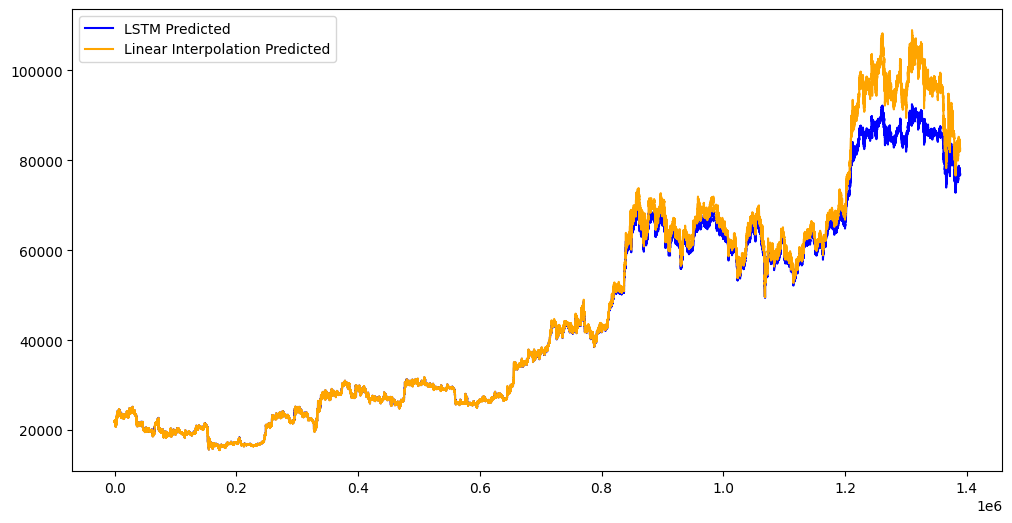

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(results["Predicted"], label="LSTM Predicted", c="blue")
plt.plot(results["Interpolated"], label="Linear Interpolation Predicted", c="orange")

plt.legend()
plt.show()